In [1]:
## import the tools
import torch
import glob
from pathlib import Path
import os
import numpy as np
from sklearn.neighbors import NearestNeighbors as NN
import glob
import pandas as pd
import ipdb
import laspy
import open3d as o3d
from tqdm.notebook import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
## import the model tools
from torch_geometric.transforms import Compose
from torch_points3d.core.data_transform import MinPoints,XYZFeature, AddFeatsByKeys, GridSampling3D, AddOnes
from torch_points3d.applications.pretrained_api import PretainedRegistry
from torch_geometric.data import Batch, Dataset, Data ,DataLoader


In [3]:
## to find the neighbor points prediction
from sklearn.neighbors import BallTree, KDTree
import numpy as np
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""
    # src : whole gt points in a file 
    tree = KDTree(candidates, leaf_size=20, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    closest = np.squeeze(indices)
    closest_dist = distances

    return closest

In [7]:
model_folder = "2023-04-18/12-08-50/"
model_name = "SEUNet18.pt"
root_path = "/home/jf/Documents/msc/torch-3dpoints-powerline/"
pl_models_path = root_path+ "outputs/" + model_folder + model_name
model = torch.load(pl_models_path)
model['run_config']['data']['dataroot'] = '/home/jf/msc_data'
torch.save(model, root_path+ "outputs/" + model_folder + model_name)
print(model['run_config']["data"]["train_transform"])

[{'transform': 'MinPoints', 'lparams': [512]}, {'transform': 'AddOnes'}, {'transform': 'AddFeatsByKeys', 'params': {'list_add_to_x': [True], 'feat_names': ['ones'], 'delete_feats': [True], 'input_nc_feats': [1]}}, {'transform': 'GridSampling3D', 'params': {'size': '${data.first_subsampling}', 'quantize_coords': True, 'mode': 'last'}}]


In [8]:
print(model['run_config']["data"])

{'task': 'segmentation', 'class': 'denmark_pl_hough.DenmarkDataset', 'name': 'Denmark', 'dataroot': '/home/jf/msc_data', 'processed_folder': 'processed_hough_20_ones', 'use_category': False, 'visualization': True, 'class_weights': 'log', 'first_subsampling': 0.004, 'train_overlap': 0.25, 'block_size_x': 0.05, 'block_size_y': 0.05, 'canny_lower': 19, 'canny_upper': 101, 'cc_area': 1500, 'hough_lines_treshold': 30, 'max_line_gap': 6, 'min_line_length': 12, 'meters_around_line': 10, 'simplify_tolerance': 8, 'outlier_voxel_size': 0.7, 'outlier_nb_neighbors': 19, 'outlier_std_ratio': 50, 'train_transform': [{'transform': 'MinPoints', 'lparams': [512]}, {'transform': 'AddOnes'}, {'transform': 'AddFeatsByKeys', 'params': {'list_add_to_x': [True], 'feat_names': ['ones'], 'delete_feats': [True], 'input_nc_feats': [1]}}, {'transform': 'GridSampling3D', 'params': {'size': '${data.first_subsampling}', 'quantize_coords': True, 'mode': 'last'}}], 'val_transform': [{'transform': 'MinPoints', 'lparams

# MAKE SURE THESE PARAM MATCHES THE ONES ABOVE !!!!!

In [8]:
## transformer
pos_z = [ "pos_z" ]
list_add_to_x = [ True ]
delete_feats = [ True ]
lparams = ['512']

first_subsampling = model['run_config']["data"]["first_subsampling"]
transform_test = Compose([MinPoints(512),
                     XYZFeature(add_x=False, add_y=False, add_z= True),
                     AddFeatsByKeys(list_add_to_x=list_add_to_x, feat_names= pos_z,delete_feats=delete_feats),
                     GridSampling3D(mode='last', size=first_subsampling, quantize_coords=True)
                     ])

In [9]:
model_pl = PretainedRegistry.from_file(pl_models_path).cuda()

INFO - 2023-04-11 12:46:59,108 - model_checkpoint - Loading checkpoint from /home/jf/Documents/msc/torch-3dpoints-powerline/outputs/2023-04-09/13-31-16/SEUnet1850Metersblock50cmvoxel.pt


loading processed train split
Total of 3213 samples in train set.
loading processed val split
Total of 269 samples in val set.
loading processed test split
Total of 390 samples in test set.


INFO - 2023-04-11 12:47:00,639 - model_checkpoint - Available weights : ['latest', 'loss_seg', 'acc', 'macc', 'miou']
INFO - 2023-04-11 12:47:00,640 - model_checkpoint - Model loaded from SEUnet1850Metersblock50cmvoxel.pt:latest
INFO - 2023-04-11 12:47:00,742 - bn_schedulers - Setting batchnorm momentum at 0.1


## Process with the normalize data

In [15]:
## load test pt with normalized

## load transform pt pre
processed_folder_name = model['run_config']['data']["processed_folder"] # "processed_hough"
data_root_path = model['run_config']['data']['dataroot'] + "/denmark"
processed_data_root_path = os.path.join(data_root_path, processed_folder_name)#"/home/jf/msc_data/denmark/processed_hough"
test_fold = processed_data_root_path + f"/test_0_({model['run_config']['data']['block_size_x']}, {model['run_config']['data']['block_size_y']})"

pre_trans_path = test_fold + "/stats.pt"
vis_out_folder = processed_data_root_path + '/vis/'

pre_transform = torch.load(pre_trans_path)

In [16]:
print(f"{pre_transform=}")


pre_transform={'room_names': ['PUNKTSKY_00005_1km_6219_494', 'PUNKTSKY_00005_1km_6211_474'], 'room_coord_min': [array([ 4.9406794e+07,  6.2190000e+08, -2.6480000e+03]), array([ 4.7416593e+07,  6.2110000e+08, -2.6480000e+03])], 'room_coord_max': [array([4.94999990e+07, 6.21971228e+08, 1.39850000e+04]), array([4.74999990e+07, 6.21199999e+08, 1.39850000e+04])], 'room_coord_scale': [array([ 4660.25,  3561.4 , 16633.  ]), array([ 4170.3 ,  4999.95, 16633.  ])], 'global_z': (-2648.0, 13985.0)}


[]

In [12]:
## loop for every files
## delete files
global_z = pre_transform['global_z']
room_names = pre_transform['room_names']
room_coord_mins = pre_transform['room_coord_min']
room_coord_maxs = pre_transform['room_coord_max']
room_coord_scales = pre_transform['room_coord_scale']
files = list(glob.glob(test_fold + "*cloud*pt"))

for file in files:
    #print(file)
    sample = os.path.join(test_fold, file)
    pt_data = torch.load(sample)
    room_index = pt_data['room_idx']
    room_name = room_names[room_index]
    vis_out = os.path.join(vis_out_folder, room_name)
    Path(vis_out_folder).mkdir(exist_ok=True, parents=True)

    room_coord_scale = room_coord_scales[room_index]
    pos_ = pt_data['points']
    pt_ori = pos_ * room_coord_scale + room_coord_mins[room_index]
    data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(pos_.shape[0]).long()))
    # data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(1).long()))
    data_s.y = torch.zeros(data_s.batch.shape).long()
    f = get_nearest(pos_, data_s.pos)


    with torch.no_grad():
        model_pl.eval()
        model_pl.set_input(data_s, "cuda")
        model_pl.forward(data_s)
    
    pre = model_pl.output.cpu().numpy()
    m = torch.nn.functional.softmax(torch.tensor(pre), dim=1)
    cla_pre = np.argmax(m, axis=1)
    pre_ori = np.arange(len(pos_))
    if len(pos_) == 1:
        print(file)
        print(data_s)
        pre_ori[0] = cla_pre[0]
    else:
        for i in pre_ori:
            pre_ori[i] = cla_pre[f[i]]
    combine_pre = np.column_stack((pt_ori, pre_ori.T))

    vis_out = vis_out_folder + room_name +'pre.txt'
    if os.path.exists(vis_out):
        file_save = open(vis_out, 'a')
    else:
        file_save = open(vis_out, 'w')

    file_save = open(vis_out_folder + room_name +'pre.txt', 'a')
    np.savetxt(file_save, combine_pre, fmt = '%1.5f')
#     file_save.write("\n")    
#     break
print("save finished")

KeyboardInterrupt: 

### Simple vis

In [33]:
## read path
filename = "PUNKTSKY_00005_1km_6211_474"
vis_out_folder
pred_path = os.path.join(vis_out_folder, filename+"pre.txt")
pred_data = pd.read_csv(pred_path, sep=" ", header=None).values
pred_data, pred_data.shape

(array([[4.74707370e+07, 6.21124992e+08, 5.27100000e+03, 0.00000000e+00],
        [4.74707270e+07, 6.21124991e+08, 5.22400000e+03, 0.00000000e+00],
        [4.74706890e+07, 6.21124986e+08, 5.22600000e+03, 0.00000000e+00],
        ...,
        [4.74875440e+07, 6.21127988e+08, 4.66400000e+03, 0.00000000e+00],
        [4.74875730e+07, 6.21127985e+08, 4.66900000e+03, 0.00000000e+00],
        [4.74875860e+07, 6.21127981e+08, 4.77100000e+03, 0.00000000e+00]]),
 (5033594, 4))

In [34]:
## vis
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib notebook

In [35]:
idx = np.arange(len(pred_data))
np.random.shuffle(idx)
idx = idx[:30000]

vmin = pred_data[idx, -1].min()
vmax = pred_data[idx, -1].max()
cm = plt.colormaps['RdYlBu']

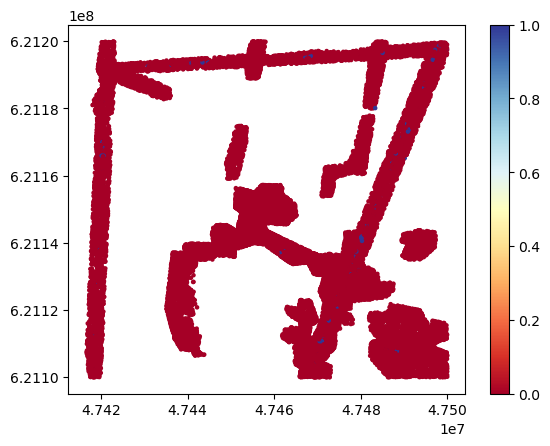

In [36]:
plt.figure()
sc = plt.scatter(pred_data[idx, 0], pred_data[idx, 1], c =pred_data[idx, -1],
                cmap=cm, vmin=vmin, vmax=vmax, s=5
            )
plt.colorbar(sc)

# Convert prediction from pt to las file

## Reading in the laspy data. Both the unprocessed and the processed data

In [37]:
normal_laz_file = os.path.join(data_root_path, "raw", "test",filename+".laz")
processed_laz_file = os.path.join(data_root_path, "raw", "test", "NewLaz", filename+".laz")
print(normal_laz_file)
print(processed_laz_file)
non_processed_laz = laspy.read(normal_laz_file, laz_backend=laspy.compression.LazBackend.LazrsParallel)
processed_laz = laspy.read(processed_laz_file, laz_backend=laspy.compression.LazBackend.LazrsParallel)
non_processed_point_data = np.stack([non_processed_laz.X, non_processed_laz.Y, non_processed_laz.Z], axis=0).transpose((1, 0))
processed_point_data = np.stack([processed_laz.X, processed_laz.Y, processed_laz.Z], axis=0).transpose((1, 0))
print(len(non_processed_point_data))
print(len(processed_point_data))


/home/jf/msc_data/denmark/raw/test/PUNKTSKY_00005_1km_6211_474.laz
/home/jf/msc_data/denmark/raw/test/NewLaz/PUNKTSKY_00005_1km_6211_474.laz
4095
4095
15599105
5050945


### Getting the powerline coordinates

In [38]:
powerline_pts = pred_data[np.where(pred_data[:,3] == 1)].copy()
powerline_pts_coord = powerline_pts[:,:-1].astype(np.int32)

#### Sanity checks for converting from pt to las data


In [39]:
print(f"There are {pred_data.shape} points in the las file")
print(f"There are {pred_data.shape} points from the pt files")
#Some points could get lost if there are not that many points in the tile


There are (5033594, 4) points in the las file
There are (5033594, 4) points from the pt files


In [40]:
print(powerline_pts_coord[:10])
print(processed_point_data[:10])

print(f"laz data x max {np.max(processed_point_data[:,0])}")
print(f"pt x max {np.max(powerline_pts_coord[:,0])}")
print(f"laz data y max {np.max(processed_point_data[:,1])}")
print(f"pt y max {np.max(powerline_pts_coord[:,1])}")
print(f"laz data z max {np.max(processed_point_data[:,2])}")
print(f"pt z max {np.max(powerline_pts_coord[:,2])}")


[[ 47470631 621124981      4992]
 [ 47470756 621124999      4708]
 [ 47470632 621124981      4924]
 [ 47470728 621124995      4690]
 [ 47470699 621124991      4673]
 [ 47470671 621124988      4656]
 [ 47470644 621124985      4640]
 [ 47470788 621124968      5117]
 [ 47470714 621124958      5245]
 [ 47470682 621124954      5240]]
[[ 47471362 621126981      4950]
 [ 47471023 621126933      5533]
 [ 47470941 621126922      5673]
 [ 47470901 621126916      5742]
 [ 47471440 621126992      4752]
 [ 47471043 621126936      5435]
 [ 47470939 621126922      5615]
 [ 47471402 621126987      4751]
 [ 47471051 621126938      5353]
 [ 47470948 621126924      5531]]
laz data x max 47499999
pt x max 47499997
laz data y max 621199999
pt y max 621199962
laz data z max 16040
pt z max 8979


### Viz the las files

In [41]:
# Visualise all data
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(non_processed_point_data)
o3d.visualization.draw_geometries([geom])
print(np.sum(non_processed_laz.classification == 14))

31418


In [42]:
# Visualise all data after removal of points
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(processed_point_data)
o3d.visualization.draw_geometries([geom])
print(np.sum(processed_laz.classification == 14))

31388


### Add dimension to processed las file 

In [43]:
processed_laz.add_extra_dim(laspy.ExtraBytesParams(
    name="prediction",
    type=np.uint8,
    description="The prediction of the model"
))

In [44]:
# Get the idx of the powerline points in the las file
idx = get_nearest(powerline_pts_coord,processed_point_data)
pred = np.zeros(len(processed_point_data))
pred[idx] = 1
processed_laz.prediction = pred

#### Viz all the powerline points

In [45]:
powerline_las = processed_laz[processed_laz.prediction == 1]
powerline_points_data = np.stack([powerline_las.X, powerline_las.Y, powerline_las.Z], axis=0).transpose((1, 0))

In [46]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(powerline_points_data)
o3d.visualization.draw_geometries([geom])

#### Save the new file

In [47]:
processed_data_root_path = os.path.join(data_root_path, processed_folder_name)#"/home/jf/msc_data/denmark/processed_hough"
eval_folder = os.path.join(processed_data_root_path, "eval")
Path(eval_folder).mkdir(exist_ok=True, parents=True)
eval_file_name = os.path.join(eval_folder, filename+".laz")
processed_laz.write(str(eval_file_name), do_compress =True, laz_backend=laspy.compression.LazBackend.LazrsParallel)

### check the individual pt


In [48]:
onesample = test_fold + "PUNKTSKY_00005_1km_6211_474_cloud_56.pt"
#onesample = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU/Powerlines/test_some/denmark/processed/test_0_(0.05, 0.05)/PUNKTSKY_00005_1km_6090_507_cloud_335.pt"
pt_data = torch.load(onesample)
pt_data['points'].shape, pt_data['points']
data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(pos_.shape[0]).long()))
# data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(1).long()))
data_s.y = torch.zeros(data_s.batch.shape).long()


FileNotFoundError: [Errno 2] No such file or directory: '/home/jf/msc_data/denmark/processed_hough_50cm/test_0_(0.05, 0.05)/PUNKTSKY_00005_1km_6211_474_cloud_56.pt'

In [ ]:
### check the individual pt

# pos_ = pt_data['points']
# data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(pos_.shape[0]).long()))
# # data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(1).long()))
# data_s.y = torch.zeros(data_s.batch.shape).long()
# f = get_nearest(pos_, data_s.pos)
# f.shape, f
# f.max(), data_s.pos.shape

# with torch.no_grad():
#     model_pl.set_input(data_s, "cuda")
#     model_pl.forward(data_s)

# pre = model_pl.output.cpu().numpy()
# pre.shape

In [ ]:
## change the model config path
# model_path = "./outputs/2022-02-16/11-00-40/PointNet_old.pt"
# model = torch.load(model_path)
# model['run_config']['data']['dataroot'] = '/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU_one/'
# torch.save(model, "./outputs/2022-02-16/11-00-40/PointNet_modified.pt")

In [ ]:
processed_split_folder = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU_for_exp_allClasses/denmark/processed/"
processed_split_folder = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU_one/denmark/processed/"

processed_split_folder = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU/Powerlines/test_some/denmark/processed"

test_fold = processed_split_folder + "test_0_(0.05, 0.05)/"
processed_file_names = list(Path(test_fold).glob("*cloud_*.pt"))
len(processed_file_names)


0